In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Finding Guido part II

We can read the graphml file of Guido van Rossum's twitterverse that we made previously. The first thing we can notice is that it is large - 16000 accounts with about 24000 edges. That's a lot more information than my laptop can hold easily. 

In [2]:
gvr_twitterverse = nx.read_graphml("/workspaces/long-island-twitter/notebooks/gvr_twitterverse.graphml")

With a little pandas magic we can see that the majority of our nodes have degree 1. That means they are only followed by 1 of the 100 GVR followers that we're working with. We can safely remove them from the graph. 

In [3]:
graph_degree = gvr_twitterverse.degree()
graph_degree_df = pd.DataFrame(graph_degree)
graph_degree_df[1].describe()

count    16779.000000
mean         2.901484
std         28.217866
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max       1010.000000
Name: 1, dtype: float64

In [4]:
gvr_twitterverse.remove_nodes_from(graph_degree_df[graph_degree_df[1]==1][0])

We are now down to about 2500 nodes and 10000 edges, which is much more reasonable to work with. 

In [5]:
len(gvr_twitterverse)

2565

We built the GVR Twitterverse as a Directed network, meaning that we care about the relationship between two accounts. GVR following an account does not entail that the account follows him back. This means each account in our network has an in-degree and an out-degree. We retrieve this information from the graph and build a dataframe that will make it easier to answer questions about this later. 

In [6]:
nodes = gvr_twitterverse.nodes(data=True)
nodes_df = pd.DataFrame(nodes)
nodes_df.columns = ['id', 'data']
nodes_data_df = pd.json_normalize(nodes_df['data'])
nodes_df = pd.concat([nodes_df, nodes_data_df], axis="columns").drop("data", axis="columns")

out_degree_df = pd.DataFrame(gvr_twitterverse.out_degree())
out_degree_df.columns = ["id", "out_degree"]
in_degree_df = pd.DataFrame(gvr_twitterverse.in_degree())
in_degree_df.columns = ["id", "in_degree"]

nodes_df = nodes_df.merge(in_degree_df).merge(out_degree_df)
nodes_df = nodes_df.set_index("id")
nodes_df

,description,location,name,username,followers_count,following_count,tweet_count,listed_count,in_degree,out_degree
id,,,,,,,,,,
1558359145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,53
814187443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,29
28397046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,12
astro_alexandra,Comms Specialist and STEM/Space Influencer 🚀 O...,"Washington, D.C.",Astro Alexandra 🪐 Space Communicator,astro_alexandra,17353.0,694.0,624.0,100.0,2,0
ben_eater,Scaling education somehow. Formerly @khanacade...,Not Provided,Ben Eater,ben_eater,18771.0,68.0,242.0,147.0,2,0
...,...,...,...,...,...,...,...,...,...,...
rob_pike,Ed is the standard text editor.,"Sydney, New South Wales",Rob Pike,rob_pike,50090.0,31.0,3569.0,1177.0,10,0
mrocklin,Open source maintainer. CEO at @CoiledHQ. In...,"Austin, TX",Matthew Rocklin,mrocklin,8294.0,97.0,5694.0,246.0,6,0
durin42,Version control hacker. Musician on the side.,Not Provided,Augie Fackler,durin42,578.0,357.0,7576.0,35.0,3,0


# Removing the Ego

In order to better see the Python communities that GVR participates in / pays attention to, we need to remove his node from the network. 


In [7]:
gvr_twitterverse.remove_node("gvanrossum")

In [8]:
nx.write_graphml(gvr_twitterverse, "gvr_ego_removed.graphml")

# Connected Components
Before we can look at network metrics, we have to take a look at our connections. As we are using a Directed Graph, we could have strongly and weakly connected components. Strongly connected components means that there is a path between nodes that obeys the direction of the edge; A -> B -> C -> A, for instance. A weakly connected component means that some parts of it are unreachable unless you ignore the edge direction, for example A -> B -> C <- A. 

As it turns out we have a lot of strongly connected components. Most of them are only one node, meaning that there are accounts in the GVR twitterverse that do not follow any other accounts in that 'verse. 

In [9]:
strongly_connected_components = [component for component in nx.strongly_connected_components(gvr_twitterverse)]
single_components = [scc.pop() for scc in strongly_connected_components if len(scc) == 1]
print(len(single_components), "/", len(gvr_twitterverse), " (", len(single_components) / len(gvr_twitterverse), ")")

2490 / 2564  ( 0.9711388455538221 )


Some of these accounts are for celebrities or notable figures and organizations in the non-Python world; heads of state, space agencies, Bill Gates. These are kind of interesting, but very few people are actually subscribing to them. Barack Obama gets the most, with about 10% of our target population subscribing. 

In [10]:
nodes_df.loc[single_components].query("followers_count > 3*10**5").sort_values(by="followers_count").head()

,description,location,name,username,followers_count,following_count,tweet_count,listed_count,in_degree,out_degree
id,,,,,,,,,,
anders_aslund,"Economist & author. Russia, Ukraine & Eastern ...","Washington, DC",Anders Åslund,anders_aslund,300088.0,4152.0,39015.0,3977.0,2,0
shanselman,"Code, OSS, STEM, Beyoncé, 🏴󠁧󠁢󠁳󠁣󠁴󠁿🇿🇼#T1D,@Hanse...","Portland, Oregon",Scott Hanselman,shanselman,305509.0,10604.0,233297.0,8600.0,8,0
WomenWhoCode,We are a 501(c)(3) non-profit dedicated to ins...,Global,Women Who Code,WomenWhoCode,307034.0,3854.0,23781.0,3325.0,7,0
danieldennett,I'm an author and philosopher of mind and cogn...,Tufts University,Daniel Dennett,danieldennett,308809.0,71.0,725.0,3771.0,2,0
hotdogsladies,"Honey, I'm a prize, and you're a catch, and we...",Mr. Farnum's Absurd Restaurant,Merlin Mann,hotdogsladies,309205.0,837.0,253.0,6934.0,2,0


More interesting are those nodes with a high in-degree, as these are accounts that were not in GVR's Python network but to which a lot of people in his network subscribe. We wouldn't want to lose these from the list as these are voices that are an important part of the network. But, we will lose them for now by saving them off to a separate file. 

In [11]:
nodes_df.loc[single_components].query("""in_degree > 15""")

,description,location,name,username,followers_count,following_count,tweet_count,listed_count,in_degree,out_degree
id,,,,,,,,,,
kushaldas,Public Interest Technologist at https://t.co/a...,Sweden,Kushal Das,kushaldas,6674.0,6644.0,107195.0,261.0,17,0
teoliphant,"Creator of SciPy, NumPy, and Numba; founder an...","Austin, TX",Travis Oliphant,teoliphant,35572.0,748.0,4947.0,989.0,26,0
holdenweb,Socialist. Loudmouth. Troublemaker. Only one o...,"Hastings, England",Steve Holden #TrussIsALiar,holdenweb,6654.0,3080.0,89093.0,339.0,19,0
simonw,"Creator of @datasetteproj, co-creator Django. ...","San Francisco, CA",Simon Willison,simonw,41454.0,5177.0,41152.0,1596.0,25,0
jacobian,mediocre and proud; he/him; some ways I might ...,Oregon,jacobian,jacobian,14569.0,50.0,24101.0,804.0,26,0
ianbicking,"Software engineer, Minneapolitan, Meta Reality...","Minneapolis, Minnesota",Ian Bicking,ianbicking,5895.0,738.0,5528.0,411.0,18,0
raymondh,Chief trainer for Mutable Minds.\nCertified Pu...,"Austin, TX",Raymond Hettinger,raymondh,78290.0,550.0,5828.0,1673.0,41,0
mariatta,🇨🇦🐍 Femail core developer • Sr. DevRel Enginee...,"Port Moody, British Columbia",Mariatta 🤦,mariatta,8794.0,485.0,10899.0,259.0,28,0
andrewgodwin,"Django/Python developer, speaker, pilot, and m...","Denver, CO, USA",Andrew Godwin,andrewgodwin,13831.0,417.0,14234.0,492.0,20,0


As a compromise, and to preserve the structure of our graph, we will keep any nodes that have more than 15 incoming connections. We will also change our graph to an undirected graph, which will allow these nodes to participate in our analysis. 

In [12]:
celebrity_nodes = nodes_df.loc[single_components].query("""in_degree < 5 or followers_count > 3*10**5""").index

In [13]:
gvr_twitterverse.remove_nodes_from(celebrity_nodes)

In [14]:
gvr_undirected = gvr_twitterverse.to_undirected()

In [15]:
nx.write_graphml(gvr_undirected, "/workspaces/long-island-twitter/data/processed/gvr_undirected.graphml")

## Density

Density is a measure of how connected the network is. A density of 1.0 is a fully connected graph; every possible connection exists. A density of 0 means there are no connections at all. In GVR's network 3% of possible connections exist. This is fairly high for a social network. 

In [16]:
nx.density(gvr_undirected)

0.03902730573322272

## Eccentricity

Eccentricity is a measure, for each node in the network, of its maximal distance from the farthest node in the network. That is, in a path of 

A -> B -> C -> D -> A

The eccentricity of A would be 3, as D is the node furthest away in the network. 

In [17]:
ecc = nx.eccentricity(gvr_undirected)

## Diameter

Diameter is a measure of the spread of a network; the larger the number, the further apart the edges of the network are. In this case, no one in the network is more than 4 hops away from the center. 

In [18]:
nx.diameter(gvr_undirected, ecc)

4

## Radius

Radius is a measure of the center of the network; it is the eccentricity of the nodes that are closest to every other node. 

In [19]:
nx.radius(gvr_undirected, ecc)

2

## Center

The Center of the network are nodes with an eccentricity equal to the radius. With GVR removed, this is the Python Software Foundation and two personal accounts, "raymondh" and "dabeaz". If GVR was still in the graph, the radius would be 1; these accounts, then, are the ones best able to keep the network going in his absence, perhaps. Or I could be reading too much into it : )

In [21]:
nx.center(gvr_undirected, ecc)

['raymondh', 'ThePSF', 'dabeaz']

## Periphery

The periphery of the network are nodes with an eccentricity equal to the radius. This turns out to be very large because it consists of those accounts who are followed by GVR's group, but who do not follow anyone in return. In some cases the accounts are deadish, i.e. they are no longer active on Twitter. This is a reflection of the truth that Twitter is somewhat of a second-rate social network (no offense intended).  

In [22]:
nx.periphery(gvr_undirected, ecc)[:10]

['necaris',
 'fullstackpython',
 'antocuni',
 'trentnelson',
 'AzureNotebooks',
 'orestis',
 'lisroach',
 'hathawsh',
 'tresseaver',
 'reaperhulk']

# Centrality

## Degree Centrality

In [23]:
from operator import itemgetter

degree_centraility = nx.degree_centrality(gvr_undirected).items()
sorted(degree_centraility, reverse=True, key=itemgetter(1))[:10]

[('ChristianHeimes', 0.46723044397463004),
 ('llanga', 0.40380549682875266),
 ('chriswithers13', 0.3678646934460888),
 ('brettsky', 0.35517970401691334),
 ('dstufft', 0.3023255813953489),
 ('haxor', 0.30021141649048627),
 ('emilyemorehouse', 0.2875264270613108),
 ('zooba', 0.2875264270613108),
 ('gjbernat', 0.2642706131078224),
 ('pganssle', 0.26004228329809725)]

## Closeness Centrality

This is a measure of how many of the shortest paths between nodes go through a given node. Such an account occupies a central position in the network; removing the node would make communication harder than otherwise. 

In [24]:
closeness_centrality = nx.closeness_centrality(gvr_undirected).items()
sorted(closeness_centrality, reverse=True, key=itemgetter(1))[:10]

[('ChristianHeimes', 0.6488340192043895),
 ('llanga', 0.6223684210526316),
 ('brettsky', 0.6064102564102564),
 ('chriswithers13', 0.6064102564102564),
 ('haxor', 0.5825123152709359),
 ('dstufft', 0.5817958179581796),
 ('emilyemorehouse', 0.5789473684210527),
 ('zooba', 0.5761266747868453),
 ('gjbernat', 0.5657894736842105),
 ('pumpichank', 0.5637663885578069),
 ('pganssle', 0.5624256837098692),
 ('markramm', 0.5584415584415584),
 ('freddrake', 0.5551643192488263),
 ('ThePSF', 0.5538641686182669),
 ('ethanhs', 0.5532163742690058),
 ('pydanny', 0.5532163742690058),
 ('moshezadka', 0.5519253208868145),
 ('Yhg1s', 0.5493612078977933),
 ('ctismer', 0.5399543378995434),
 ('pyblogsal', 0.536281179138322),
 ('jakevdp', 0.5350678733031674),
 ('nedbat', 0.532058492688414),
 ('tjguk', 0.5314606741573034),
 ('1st1', 0.5296752519596865),
 ('andrew_svetlov', 0.5296752519596865),
 ('wesmckinn', 0.5267260579064588),
 ('pyladies', 0.5255555555555556),
 ('pycon', 0.5238095238095238),
 ('raymondh', 0.522

In [29]:
page_rank = nx.pagerank(gvr_undirected).items()
sorted(page_rank, reverse=True, key=itemgetter(1))[:10]

[('ChristianHeimes', 0.023524684566586736),
 ('llanga', 0.019818599363752753),
 ('chriswithers13', 0.01835889647128512),
 ('brettsky', 0.017466671519767028),
 ('haxor', 0.015053664881066497),
 ('dstufft', 0.015021243291453018),
 ('zooba', 0.014467136815826571),
 ('emilyemorehouse', 0.014175565544017226),
 ('pganssle', 0.013435879894530873),
 ('gjbernat', 0.012989717249462835)]

# Cliques

Cliques are perfectly connected (every possible connection is made) groups of nodes. NetworkX has utilities for finding cliques, but we have to process the results to find the maximal (largest) cliques in the network. In our case, this turns out to be multiple combinations of nodes forming 13-cliques. 

In [30]:
cliques = list(nx.find_cliques(gvr_undirected))

In [31]:
max([len(clique) for clique in cliques])

13

In [32]:
maximal_cliques = list(filter(lambda x: len(x) == 13, cliques))

We merge the list of lists into a single list of individuals that we deduplicate using a set. We can then get the subgraph formed by all these individuals to get some idea about how these accounts are connected. 

In [33]:
import itertools

maximal_clique_members = set(list(itertools.chain.from_iterable(maximal_cliques)))

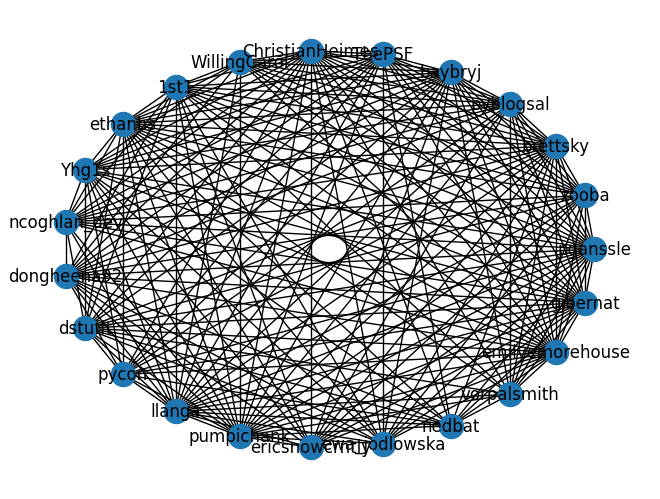

In [34]:
big_clique = gvr_undirected.subgraph(maximal_clique_members).copy()
nx.draw_circular(big_clique, with_labels=True)